---

# **Project 3: Grad-CAM**  

*(Visualizing Class Activation Maps to Improve Deep Learning Interpretability)*  

Grad-CAM (Gradient-weighted Class Activation Mapping) is a technique used to interpret and visualize the decisions made by convolutional neural networks (CNNs). It highlights the regions of an input image that are most influential in the network's prediction for a specific class. This helps in understanding which parts of the image the model focuses on when making predictions, thereby enhancing the interpretability of deep learning models.  

Grad-CAM computes the contribution of activations from a given convolutional layer using the gradients of the predicted class with respect to the activation maps:  

$$
\alpha_k^c = \frac{1}{Z} \sum_i \sum_j \frac{\partial y^c}{\partial A_{ij}^k}
$$

where $\alpha_k^c$ represents the importance of the activations in layer $k$ for class \( c \), and $A_{ij}^k$ is the activation at position $(i, j)$.  

---

## **How Grad-CAM Works**  

1. **Forward Pass**: The input image is passed through the CNN to obtain raw class scores (logits) before the softmax layer.  

2. **Compute Gradients**: The gradients of the score for the target class (e.g., "bird") are computed with respect to the feature maps of the last convolutional layer. These gradients indicate the importance of each feature map for the target class.  

3. **Global Average Pooling**: The gradients are globally averaged to obtain the weights for each feature map. These weights represent the importance of each feature map for the target class.  

4. **Weighted Combination**: Each feature map is multiplied by its corresponding weight and summed to generate a coarse localization map (class activation map).  

5. **ReLU Activation**: A ReLU (Rectified Linear Unit) activation is applied to the class activation map to retain only the features that positively influence the target class.  

6. **Upsampling**: The class activation map is upsampled to the size of the input image, enabling visualization of the most important regions for the prediction.  

---

## **Application: Visualizing Class Activation Maps for an Image of a Bird on a Branch**  

Let’s go through the steps to generate a Grad-CAM visualization for an image of a bird on a branch. This will help us understand which parts of the image the model considers most relevant when classifying the bird.  

---

In [191]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing import image as keras_image
import matplotlib.pyplot as plt
import cv2
import os
from matplotlib import cm
from IPython.display import Image, display

---

## **Downloading and Displaying the Input Image**

We define the URL of the target image (an image of a bird on a branch) and set the local file name. we download it using Keras utilities. The image is then displayed.


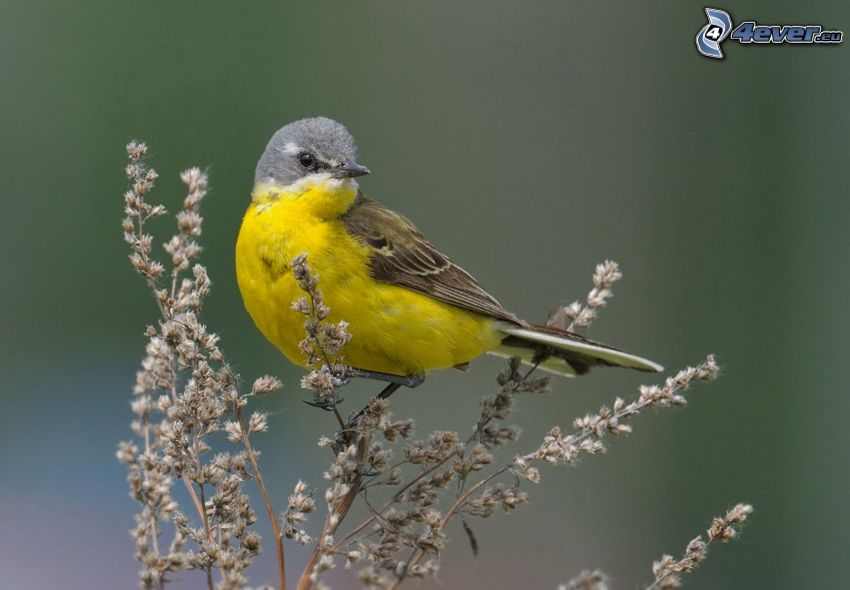

In [200]:
# URL of the chosen image (bird on a branch)
IMAGE_URL = "https://th.bing.com/th/id/OIP.MMAbzgmHjIRMkaazc69xZwHaFI?rs=1&pid=ImgDetMain"
# Local file name for saving the image
IMAGE_PATH = "oiseau1.jpg"
# Input size for VGG16 (width, height)
IMG_SIZE = (224, 224)

# --- Download the image ---
if not os.path.exists(IMAGE_PATH):
    IMAGE_PATH = keras.utils.get_file("oiseau1.jpg", IMAGE_URL)

# Display the downloaded image
display(Image(IMAGE_PATH))

---

## **Preprocessing the Image**

The function `get_img_array` loads the image from disk, resizes it to the required dimensions, converts it to a NumPy array, and adds a batch dimension so that it can be fed into the model.


In [193]:
def get_img_array(img_path, size):
    """
    Load and resize the image to the specified size.
    Returns a numpy array with a batch dimension.
    """
    # Load image using Keras utility and resize it
    img = keras_image.load_img(img_path, target_size=size)
    # Convert image to array
    array = keras_image.img_to_array(img)
    # Expand dimensions to create a batch of size 1
    array = np.expand_dims(array, axis=0)
    return array

---

## **The Grad-CAM Algorithm**

This section defines the core function `make_gradcam_heatmap` which implements Grad-CAM. The function takes a preprocessed image, the model, the name of the last convolutional layer, and a list of classifier layers to build a separate classifier model. It then computes the gradient of the predicted class (or a specified prediction rank) with respect to the activations of the last convolutional layer. Finally, it combines the gradients with the activations to produce a heatmap.

In [194]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names, prediction_rank=1):
    """
    Generate the Grad-CAM heatmap for the given image.
    
    :param img_array: Preprocessed image numpy array with batch dimension.
    :param model: Pre-trained full model.
    :param last_conv_layer_name: Name of the last convolutional layer.
    :param classifier_layer_names: List of classifier layer names.
    :param prediction_rank: Class rank to apply Grad-CAM (1 for top prediction).
    :return: Normalized heatmap (values between 0 and 1).
    """
    # --- Part 1: Extract activations from the last convolutional layer ---
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)
    
    # --- Part 2: Build the classifier model ---
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)
    
    # --- Part 3: Compute gradients using GradientTape ---
    with tf.GradientTape() as tape:
        # Get activations from the last conv layer
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Pass activations through the classifier model to obtain predictions
        preds = classifier_model(last_conv_layer_output)
        # Select the prediction of interest (default is the top prediction)
        pred_index = tf.argsort(preds)[0][-prediction_rank]
        top_class_channel = preds[:, pred_index]
    
    # Compute the gradient of the target class output w.r.t. the activations
    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    
    # Average the gradients over the spatial dimensions
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Multiply each channel in the feature map array by the corresponding gradient importance
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]
    
    # Compute the heatmap by averaging over all channels
    heatmap = np.mean(last_conv_layer_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)  # Keep only positive values
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1e-8
    return heatmap

---

## **Overlaying the Heatmap on the Original Image**

The function `overlay_heatmap_on_image` overlays the computed heatmap onto the original image. It first resizes the heatmap to match the original image dimensions, applies a colormap to visualize the heatmap in color, and then blends the heatmap with the original image using an alpha parameter for transparency.



In [195]:
def overlay_heatmap_on_image(img_path, heatmap, alpha=0.4, save_path="gradcam_output.jpg"):
    """
    Overlay the heatmap on the original image and save the result.
    
    :param img_path: Path to the original image.
    :param heatmap: Grad-CAM heatmap (values between 0 and 1).
    :param alpha: Transparency factor for the overlay.
    :param save_path: Path to save the resulting image.
    :return: Display the overlaid image.
    """
    # Load the original image
    img = keras_image.load_img(img_path)
    img = keras_image.img_to_array(img)
    
    # Resize heatmap to match the image dimensions
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    
    # Apply a colormap (here using the JET colormap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    jet_heatmap = cv2.resize(heatmap_color, (img.shape[1], img.shape[0]))
    
    # Convert colorized heatmap to an image format compatible with Keras
    jet_heatmap = keras_image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras_image.img_to_array(jet_heatmap)
    
    # Overlay the heatmap on the original image using the specified transparency
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras_image.array_to_img(superimposed_img)
    
    # Save and display the final image
    superimposed_img.save(save_path)
    display(Image(save_path))

---

## **Model Loading, Preprocessing, and Prediction**
We load the pre-trained VGG16 model (trained on ImageNet), preprocess the image, and perform predictions. The softmax layer is removed so that the Grad-CAM heatmap can be computed using the raw activations.

In [196]:
# Load the VGG16 model pre-trained on ImageNet
model = vgg16.VGG16(weights='imagenet')

# Preprocess the image:
# 1. Load the image and resize it to the required dimensions.
# 2. Preprocess it using VGG16's specific preprocessing function.
img_array = get_img_array(IMAGE_PATH, IMG_SIZE)
img_array = vgg16.preprocess_input(img_array)

# Make predictions with the model and print the top predictions.
try:
    preds = model.predict(img_array)
    print("Top 1 Prediction:", vgg16.decode_predictions(preds, top=1)[0])
    print("Top 3 Predictions:", vgg16.decode_predictions(preds, top=3)[0])
except Exception as e:
    print(f"Error during prediction: {e}")
    exit()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
Top 1 Prediction: [('n01531178', 'goldfinch', np.float32(0.99330634))]
Top 3 Predictions: [('n01531178', 'goldfinch', np.float32(0.99330634)), ('n01530575', 'brambling', np.float32(0.0033400345)), ('n01537544', 'indigo_bunting', np.float32(0.0020040602))]


---

## **Generating and Visualizing the Grad-CAM Heatmap**

We now generate the Grad-CAM heatmap for the input image. We specify the last convolutional layer (`block5_conv3`) and the subsequent classifier layers. The heatmap is displayed separately before being overlaid on the original image.


c:\Users\somem\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_544']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


<Figure size 600x600 with 0 Axes>

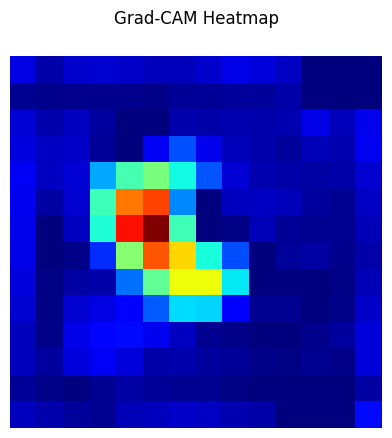

In [197]:
# Define the names of the last conv layer and classifier layers.
last_conv_layer_name = "block5_conv3"
classifier_layer_names = ["block5_pool", "flatten", "fc1", "fc2", "predictions"]

# Generate the Grad-CAM heatmap for the preprocessed image.
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)

# Display the standalone heatmap using a matplotlib colormap.
plt.figure(figsize=(6, 6))
plt.matshow(heatmap, cmap="jet")
plt.title("Grad-CAM Heatmap")
plt.axis("off")
plt.show()


---

## **Overlaying the Heatmap and Displaying the Result**

Finally, we overlay the generated heatmap on the original image to obtain a composite visualization that highlights the important regions used by the model for prediction.

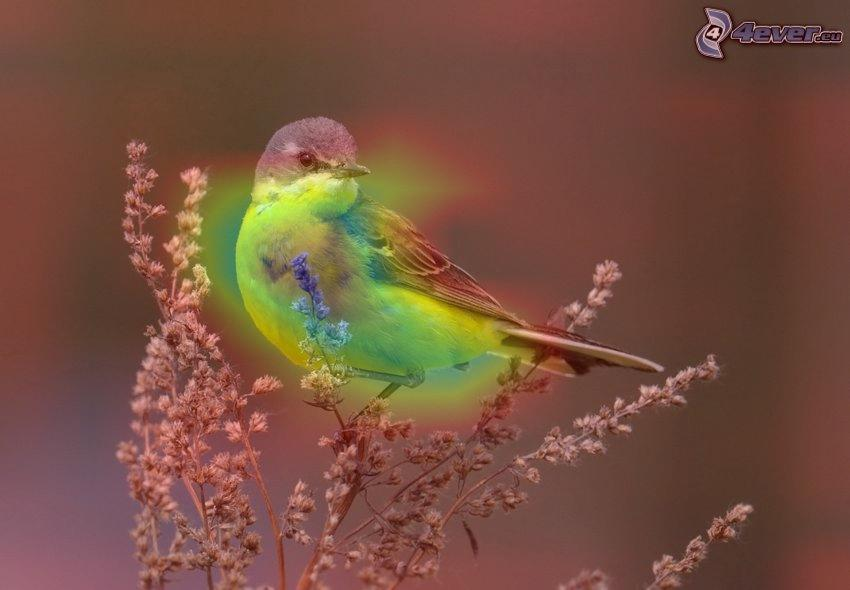

In [198]:
# Overlay the heatmap on the original image.
overlay_heatmap_on_image(IMAGE_PATH, heatmap, alpha=0.4, save_path="gradcam_output.jpg")

---

## **Conclusion**

Grad-CAM is a powerful tool for interpreting deep learning models, especially in computer vision tasks. By visualizing the class activation maps, we can gain insights into which parts of the image the model is focusing on when making predictions. This can help in debugging the model, understanding its behavior, and increasing trust in its decisions.

In the example above, we applied Grad-CAM to an image of a bird on a branch, and the resulting heatmap highlighted the regions of the image that were most influential in the model's prediction of the "bird" class. This visualization helps us understand that the model is indeed focusing on the bird and not on irrelevant parts of the image, such as the branch or the background.